In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [3]:
print("\nTraining Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)


Training Data Shape: (15533, 18)
Test Data Shape: (5225, 17)


In [4]:
print("\nFIRST FEW ROWS:")
print(train_df.head())

print("\n DATA TYPES:")
print(train_df.dtypes)

print("\n MISSING VALUES:")
missing = train_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values!")

print("\n BASIC STATISTICS:")
print(train_df.describe())

print("\n TARGET VARIABLE DISTRIBUTION:")
target_dist = train_df['WeightCategory'].value_counts()
print(target_dist)
print(f"\nClass Balance:")
for cat, count in target_dist.items():
    pct = (count / len(train_df)) * 100
    print(f"  {cat}: {count} ({pct:.2f}%)")


FIRST FEW ROWS:
   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS       WeightCateg

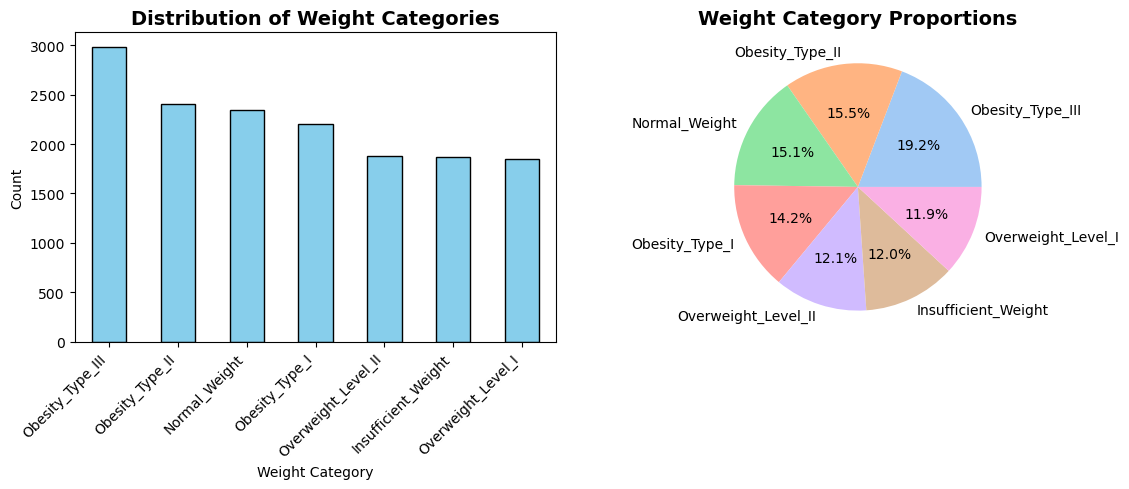

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_df['WeightCategory'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Weight Categories', fontsize=14, fontweight='bold')
plt.xlabel('Weight Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
train_df['WeightCategory'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Weight Category Proportions', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

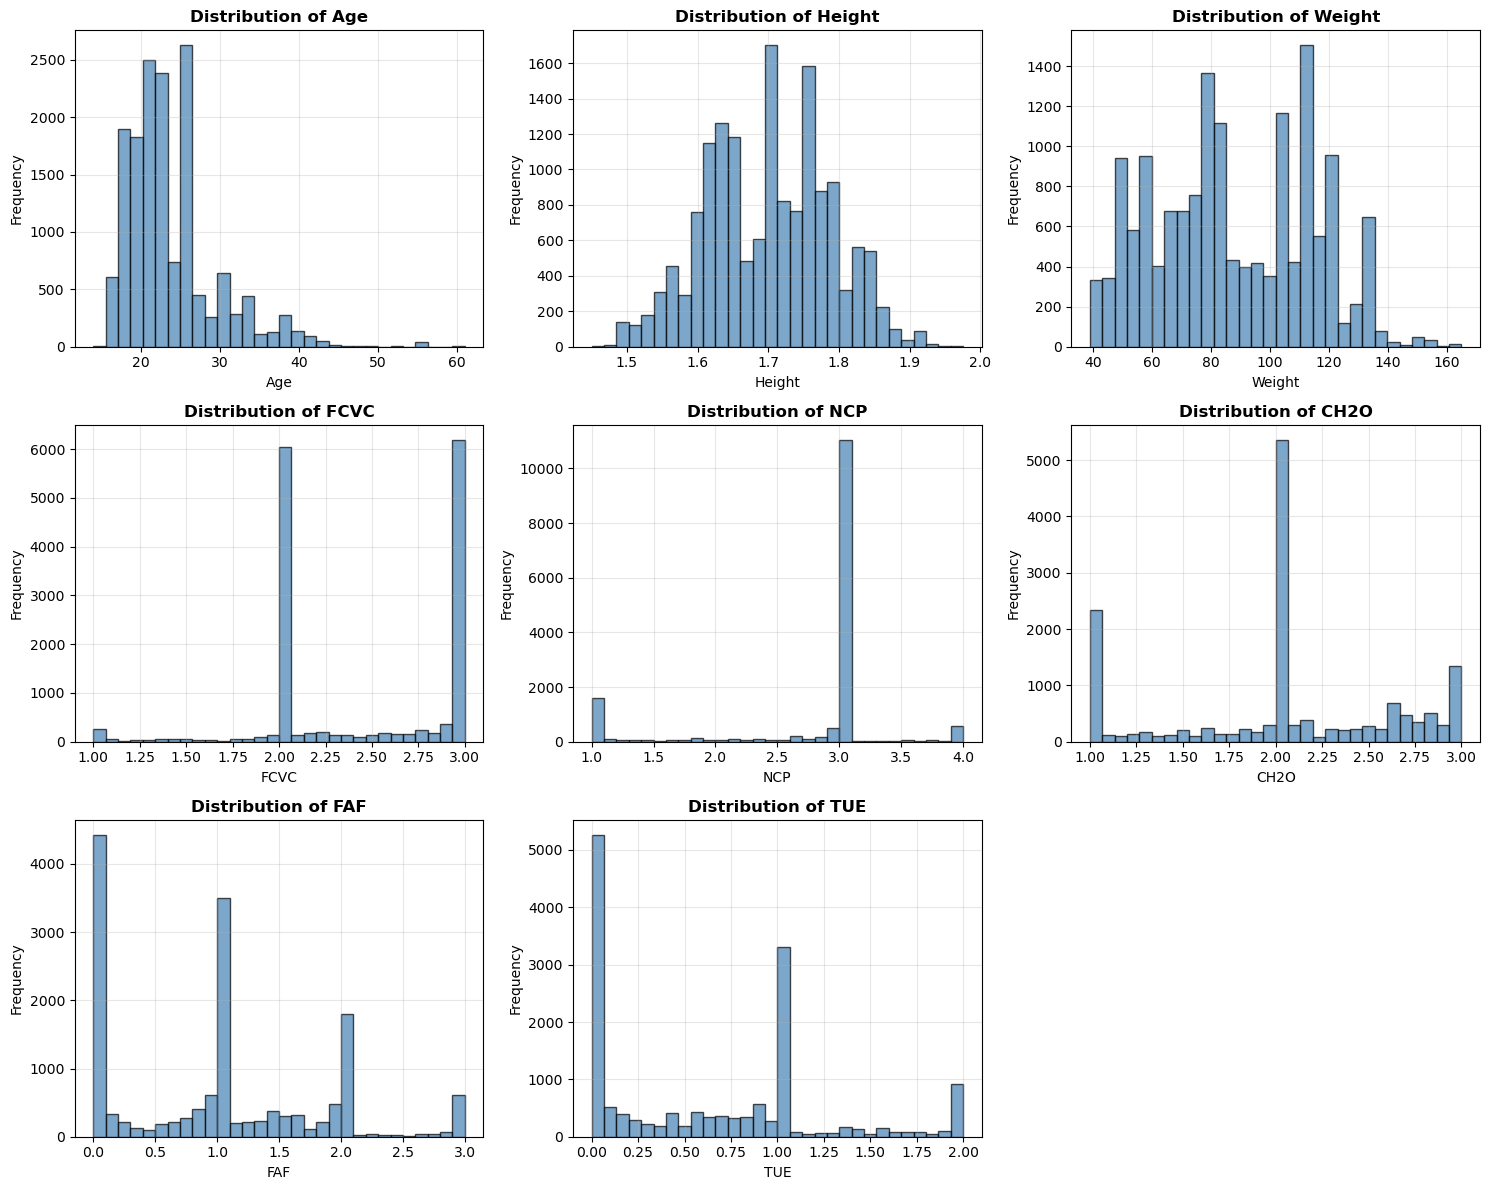

In [6]:
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id']]

if len(numerical_cols) > 0:
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].hist(train_df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


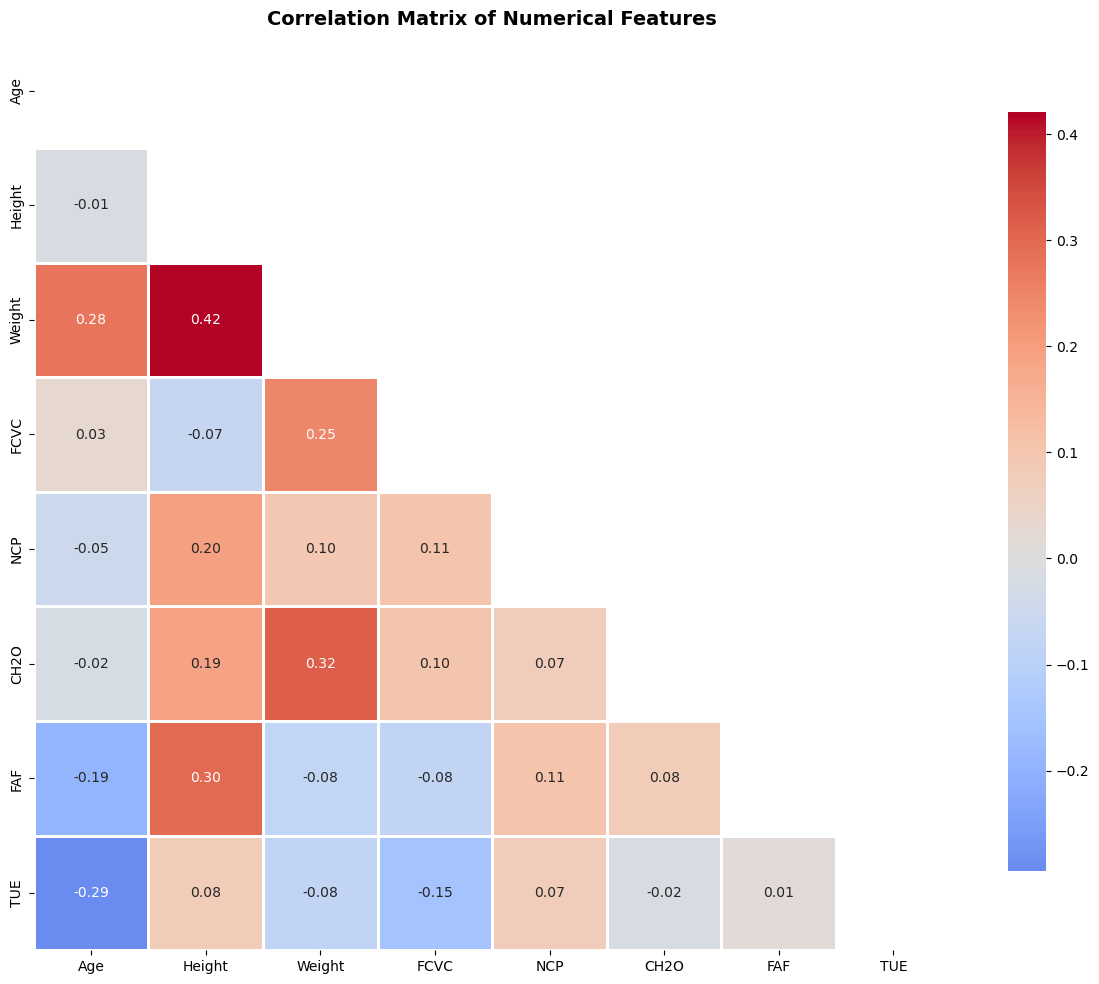


 Highly Correlated Features (|correlation| > 0.7):
  No highly correlated features found


In [7]:
if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = train_df[numerical_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n Highly Correlated Features (|correlation| > 0.7):")
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr:
        for feat1, feat2, corr_val in high_corr:
            print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")
    else:
        print("  No highly correlated features found")


 Feature Distributions by Weight Category:


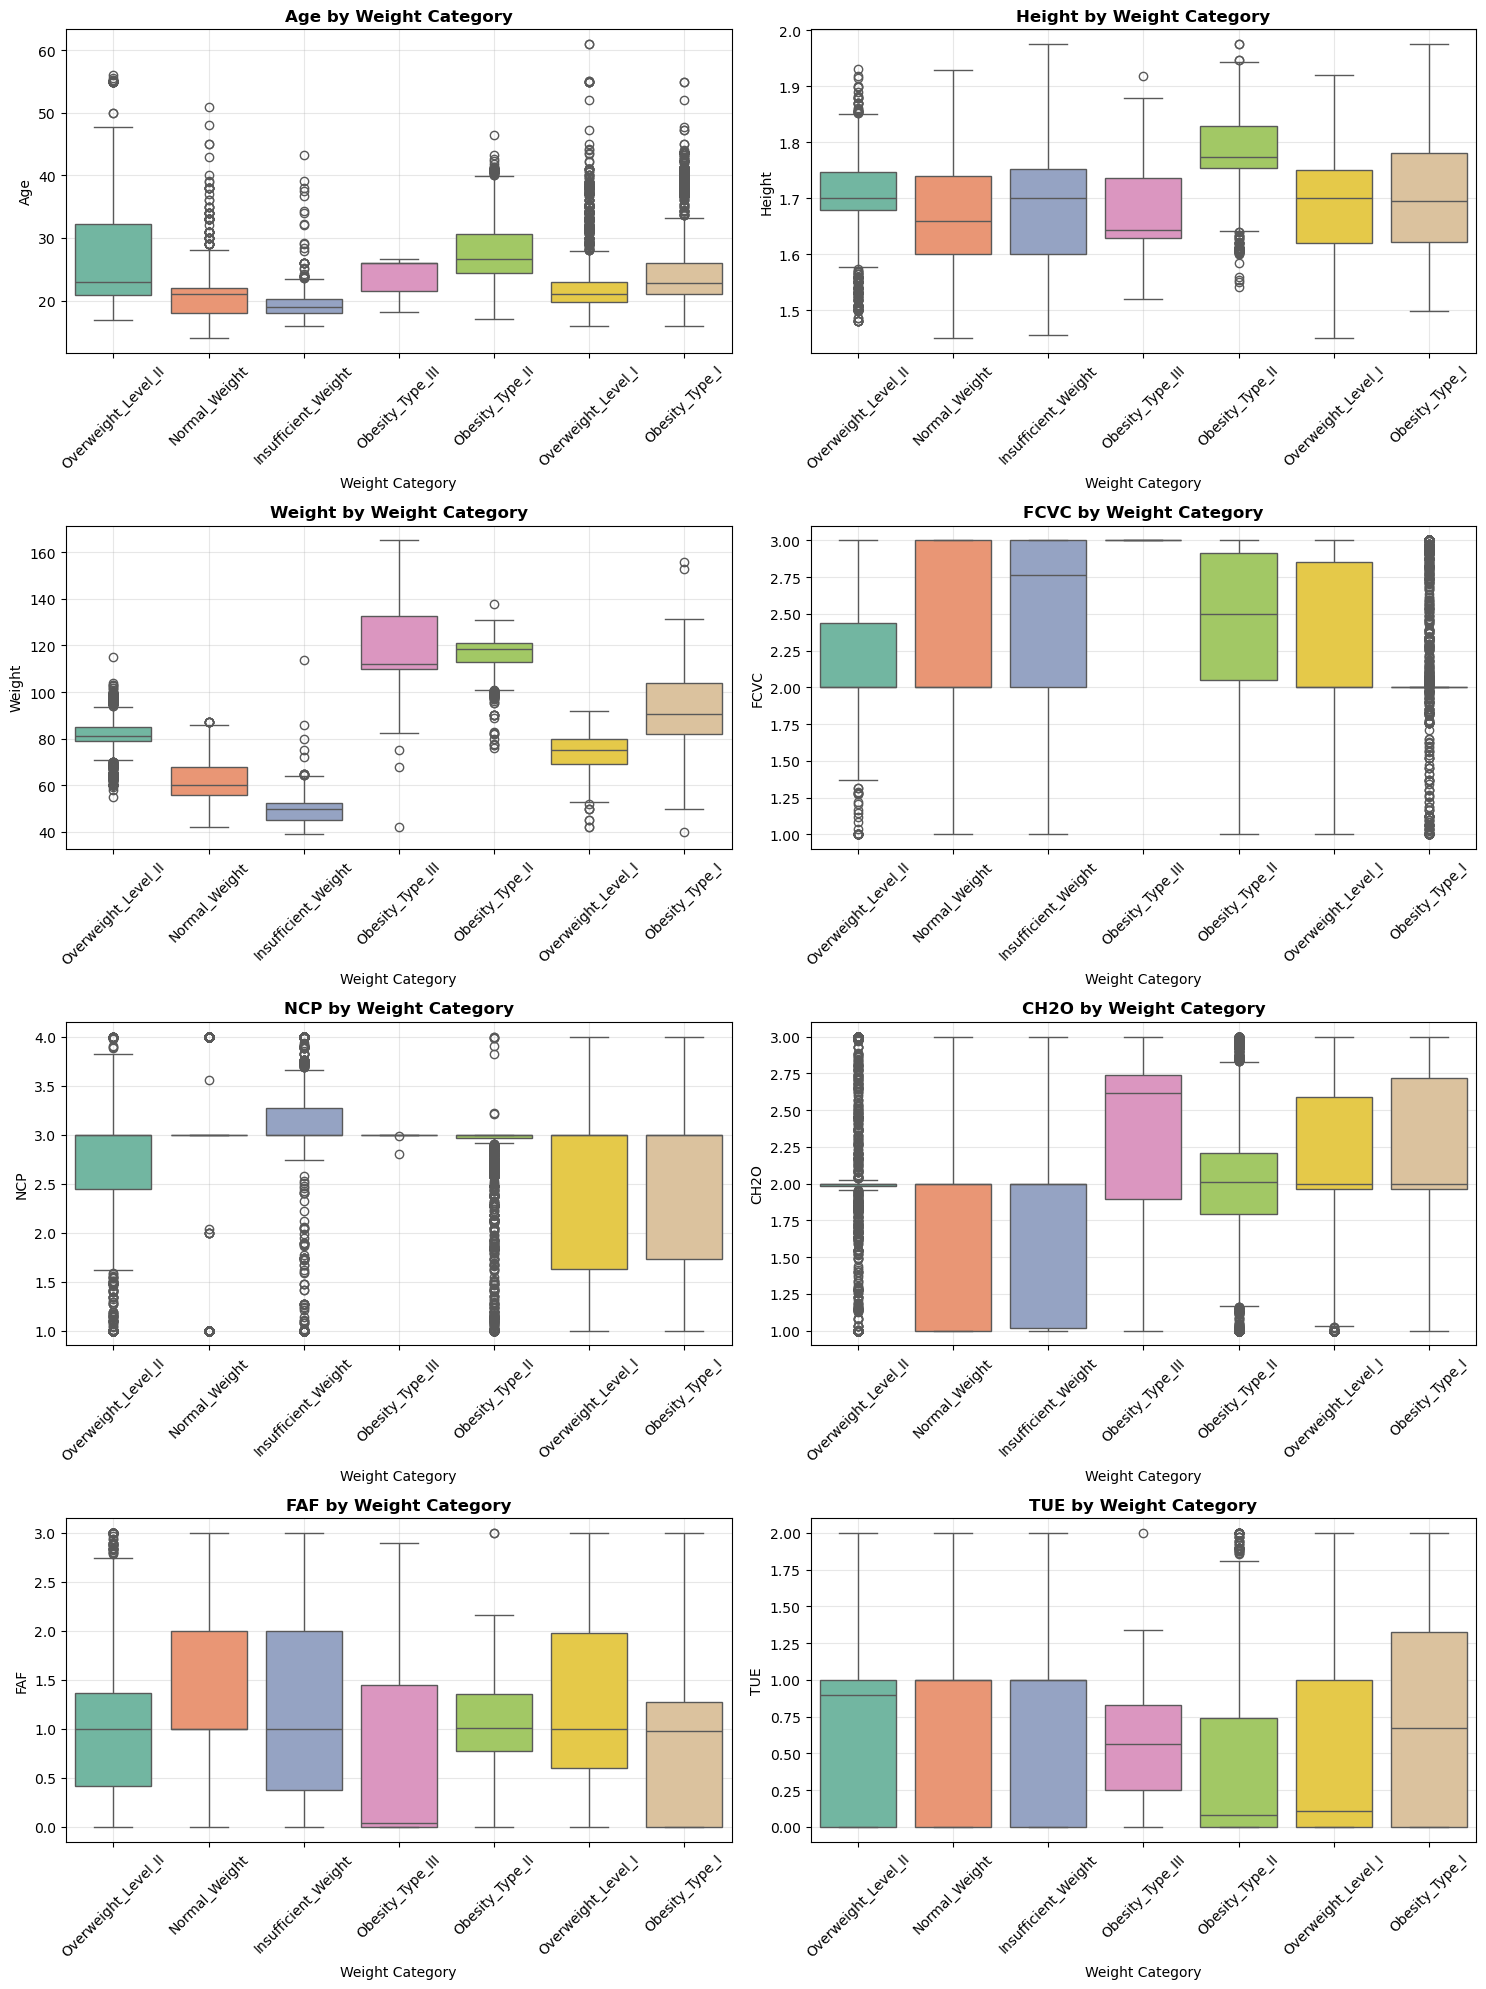

In [8]:
print("\n Feature Distributions by Weight Category:")

important_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
available_features = [f for f in important_features if f in train_df.columns]

if available_features:
    n_cols = 2
    n_rows = (len(available_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(available_features):
        sns.boxplot(data=train_df, x='WeightCategory', y=col, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{col} by Weight Category', fontweight='bold', fontsize=12)
        axes[idx].set_xlabel('Weight Category')
        axes[idx].set_ylabel(col)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(alpha=0.3)
    for idx in range(len(available_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

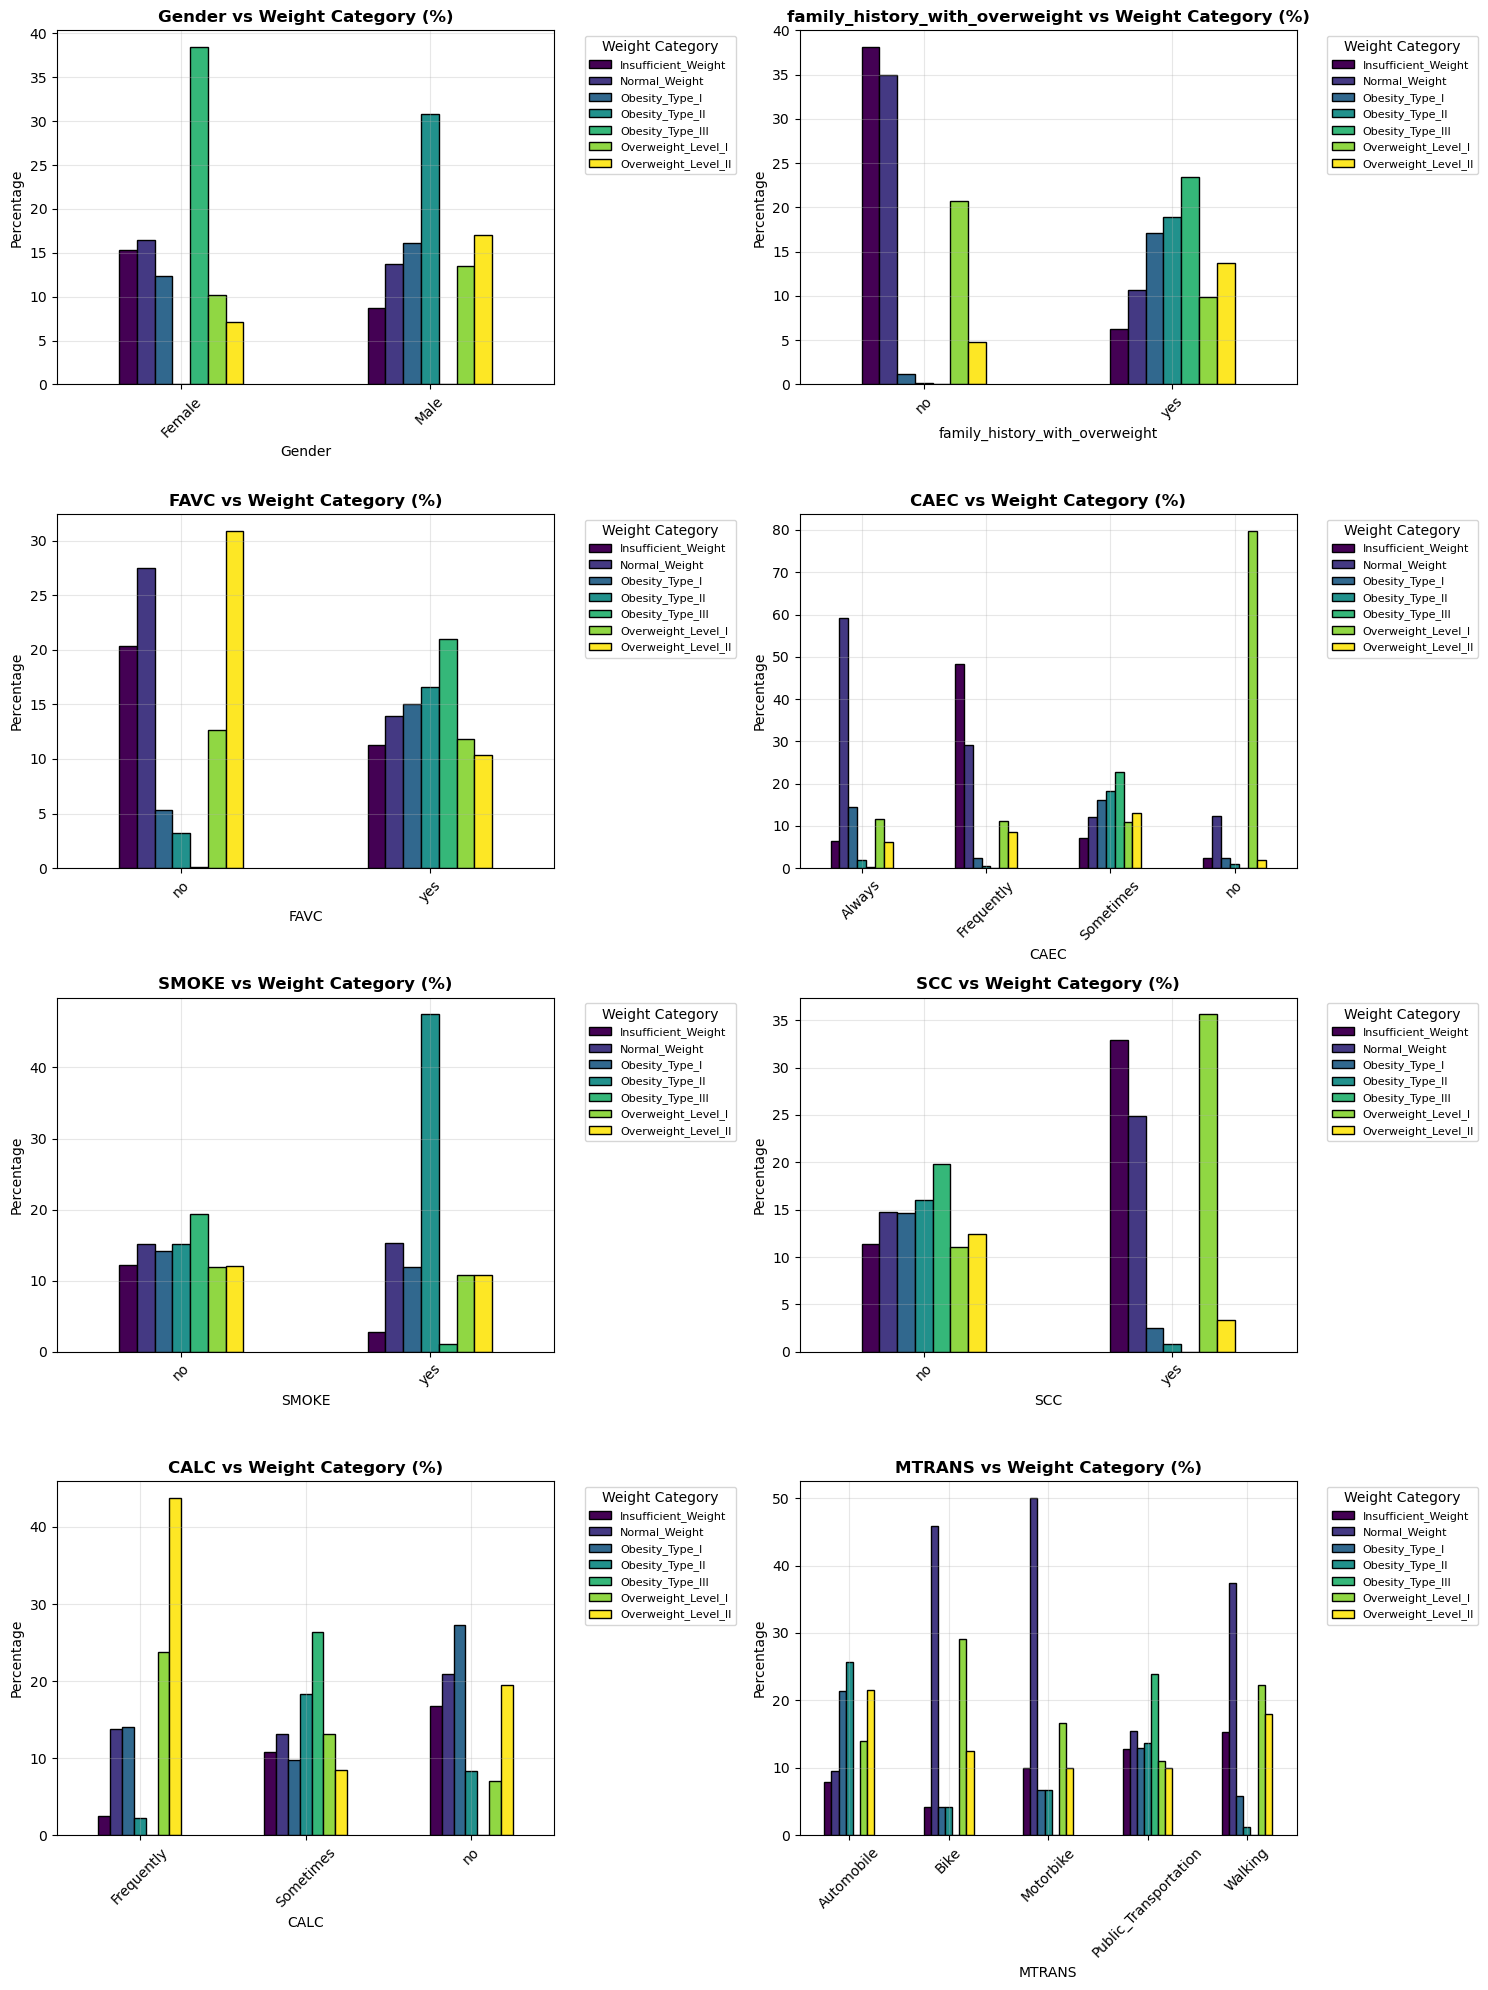

In [9]:
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
available_cat = [col for col in categorical_cols if col in train_df.columns]

if available_cat:
    n_cols = 2
    n_rows = (len(available_cat) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(available_cat):
        # Count plot
        cross_tab = pd.crosstab(train_df[col], train_df['WeightCategory'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], colormap='viridis', edgecolor='black')
        axes[idx].set_title(f'{col} vs Weight Category (%)', fontweight='bold', fontsize=12)
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(title='Weight Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(available_cat), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


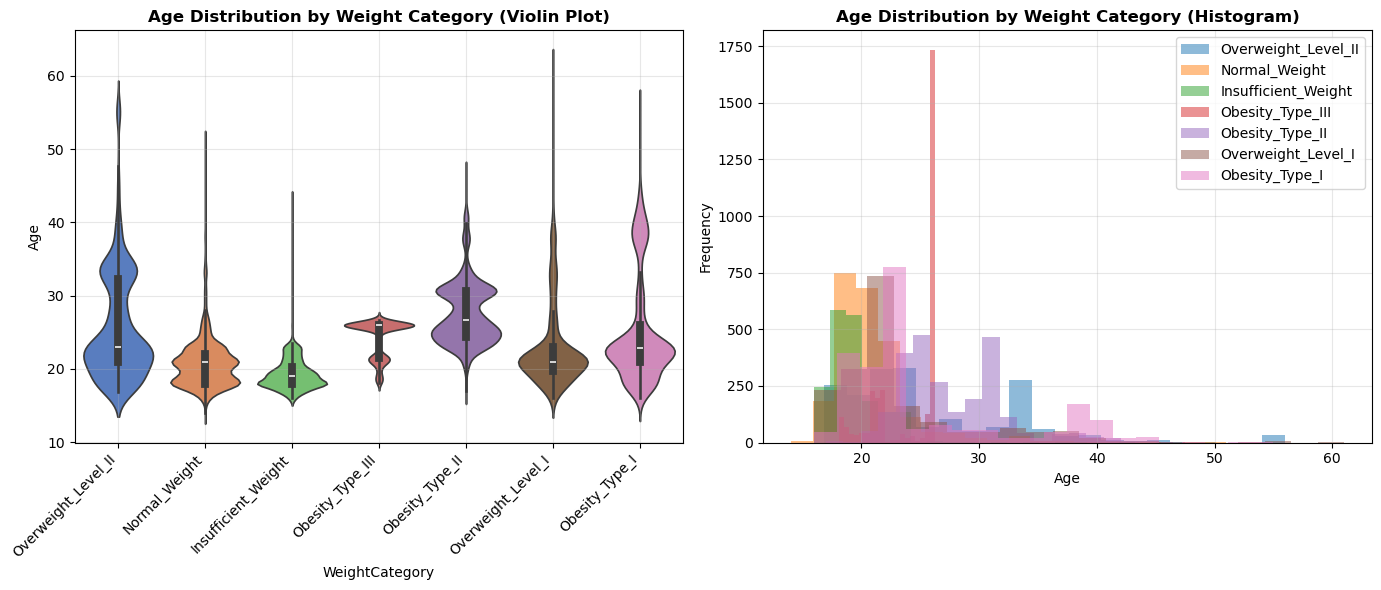

In [10]:
if 'Age' in train_df.columns:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.violinplot(data=train_df, x='WeightCategory', y='Age', palette='muted')
    plt.title('Age Distribution by Weight Category (Violin Plot)', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for category in train_df['WeightCategory'].unique():
        subset = train_df[train_df['WeightCategory'] == category]['Age']
        plt.hist(subset, alpha=0.5, label=category, bins=20)
    plt.title('Age Distribution by Weight Category (Histogram)', fontweight='bold')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

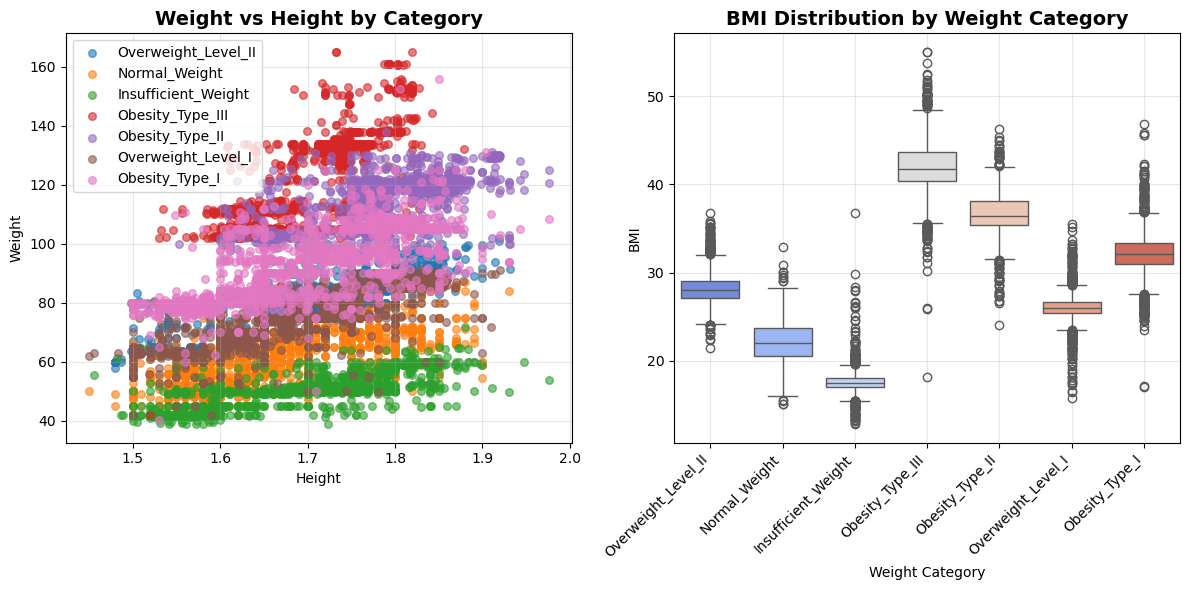

In [11]:
if 'Weight' in train_df.columns and 'Height' in train_df.columns:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    for category in train_df['WeightCategory'].unique():
        subset = train_df[train_df['WeightCategory'] == category]
        plt.scatter(subset['Height'], subset['Weight'], alpha=0.6, label=category, s=30)
    plt.title('Weight vs Height by Category', fontweight='bold', fontsize=14)
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Calculate BMI if not exists
    train_df['BMI_temp'] = train_df['Weight'] / (train_df['Height'] ** 2)
    sns.boxplot(data=train_df, x='WeightCategory', y='BMI_temp', palette='coolwarm')
    plt.title('BMI Distribution by Weight Category', fontweight='bold', fontsize=14)
    plt.xlabel('Weight Category')
    plt.ylabel('BMI')
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)
    train_df.drop('BMI_temp', axis=1, inplace=True)
    
    plt.tight_layout()
    plt.show()


In [12]:
print("\nSUMMARY STATISTICS BY WEIGHT CATEGORY:")
if 'Age' in train_df.columns:
    print("\nAge Statistics:")
    print(train_df.groupby('WeightCategory')['Age'].describe().round(2))

if 'Weight' in train_df.columns:
    print("\nWeight Statistics:")
    print(train_df.groupby('WeightCategory')['Weight'].describe().round(2))

if 'Height' in train_df.columns:
    print("\nHeight Statistics:")
    print(train_df.groupby('WeightCategory')['Height'].describe().round(2))



SUMMARY STATISTICS BY WEIGHT CATEGORY:

Age Statistics:
                      count   mean   std    min    25%    50%    75%    max
WeightCategory                                                             
Insufficient_Weight  1870.0  19.34  2.26  16.00  18.00  19.00  20.23  43.24
Normal_Weight        2345.0  20.85  3.53  14.00  18.00  21.00  22.00  51.00
Obesity_Type_I       2207.0  25.06  7.27  16.00  21.00  22.85  26.00  55.00
Obesity_Type_II      2403.0  27.67  4.23  17.00  24.42  26.68  30.61  46.49
Obesity_Type_III     2983.0  24.09  2.59  18.11  21.50  25.96  26.00  26.70
Overweight_Level_I   1844.0  23.08  5.97  16.00  19.69  21.00  23.00  61.00
Overweight_Level_II  1881.0  25.88  7.57  16.83  20.88  23.00  32.26  56.00

Weight Statistics:
                      count    mean    std   min     25%     50%     75%  \
WeightCategory                                                             
Insufficient_Weight  1870.0   49.95   5.88  39.0   45.00   50.00   52.63   
Normal_Weig

In [13]:
print("\nPreprocessing data...")

def preprocess_data(df):
    df = df.copy()
    
    # Handle missing values
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # Encode binary yes/no columns
    binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'yes': 1, 'no': 0})
    
    # Encode categorical columns
    categorical_cols = ['Gender', 'CAEC', 'CALC', 'MTRANS']
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    return df

# Preprocess
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)

print("Data preprocessing completed")
print(f"Total features: {len(train_processed.columns)- 2}")


Preprocessing data...
Data preprocessing completed
Total features: 16


In [14]:
print("\nPreparing features and target...")

X = train_processed.drop(['WeightCategory', 'id'], axis=1, errors='ignore')
y = train_processed['WeightCategory']

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Feature columns: {list(X.columns)}")
print(f"Target classes: {le_target.classes_}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nTraining set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")


Preparing features and target...
Feature columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Target classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']

Training set: (12426, 16)
Validation set: (3107, 16)


In [15]:
print("HYPERPARAMETER TUNING")
X_full = train_processed.drop(['WeightCategory', 'id'], axis=1, errors='ignore')
y_full = le_target.transform(train_processed['WeightCategory'])

# Scale full data
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Calculate sample weights for full data
sample_weights_full = compute_sample_weight('balanced', y_full)
print("Using FULL training data for tuning (better generalization)")

HYPERPARAMETER TUNING
Using FULL training data for tuning (better generalization)


In [16]:
param_distributions = {
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'max_depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'min_child_weight': [1, 3, 5, 7, 9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.3, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0],
}

# Base model
xgb_base = xgb.XGBClassifier(
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)


In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=5, 
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit with sample weights
random_search.fit(X_full_scaled, y_full, sample_weight=sample_weights_full)

print("\nHyperparameter tuning completed!")
print(f"Best CV Score: {random_search.best_score_:.4f} ({random_search.best_score_*100:.2f}%)")

print("\nBest Parameters Found:")
print("="*60)
for param, value in sorted(random_search.best_params_.items()):
    print(f"   {param:20s}: {value}")
print("="*60)

# Get best model (already trained on full data during CV)
xgb_model = random_search.best_estimator_

print("\nBest model is ready!")
print("   (Trained on full training data with cross-validation)")

# Now evaluate on the validation split for comparison
print("\nEvaluating on validation split...")

# Re-create the validation split for evaluation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_full_scaled, y_full, test_size=0.2, random_state=42, stratify=y_full
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [45]:
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Predictions on validation split
y_pred = xgb_model.predict(X_val_split)
y_train_pred = xgb_model.predict(X_train_split)

# Accuracies
val_accuracy = accuracy_score(y_val_split, y_pred)
train_accuracy = accuracy_score(y_train_split, y_train_pred)

print(f"\nTraining Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"CV Accuracy:         {random_search.best_score_:.4f} ({random_search.best_score_*100:.2f}%)")
print(f"Correct predictions: {(y_pred == y_val_split).sum()} / {len(y_val_split)}")
print(f"Wrong predictions: {(y_pred != y_val_split).sum()}")

# Overfitting check
gap = train_accuracy - val_accuracy
if gap < 0.02:
    print(f"\nExcellent generalization! (gap: {gap:.4f})")
elif gap < 0.05:
    print(f"Good generalization (gap: {gap:.4f})")
else:
    print(f"Some overfitting detected (gap: {gap:.4f})")


MODEL EVALUATION

Training Accuracy:   0.9388 (93.88%)
Validation Accuracy: 0.9450 (94.50%)
CV Accuracy:         0.9131 (91.31%)
Correct predictions: 3335 / 3529
Wrong predictions: 194

Excellent generalization! (gap: -0.0062)



DETAILED CLASSIFICATION REPORT:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.96      0.96       428
      Normal_Weight       0.92      0.92      0.92       526
     Obesity_Type_I       0.95      0.94      0.94       512
    Obesity_Type_II       0.99      0.99      0.99       540
   Obesity_Type_III       1.00      1.00      1.00       662
 Overweight_Level_I       0.87      0.87      0.87       427
Overweight_Level_II       0.90      0.90      0.90       434

           accuracy                           0.95      3529
          macro avg       0.94      0.94      0.94      3529
       weighted avg       0.94      0.95      0.94      3529

PER-CLASS ACCURACY:
Insufficient_Weight           : 0.9626 (96.26%)
Normal_Weight                 : 0.9202 (92.02%)
Obesity_Type_I                : 0.9375 (93.75%)
Obesity_Type_II               : 0.9944 (99.44%)
Obesity_Type_III              : 0.9985 (99.85%)
Overweight_Level_I            : 0

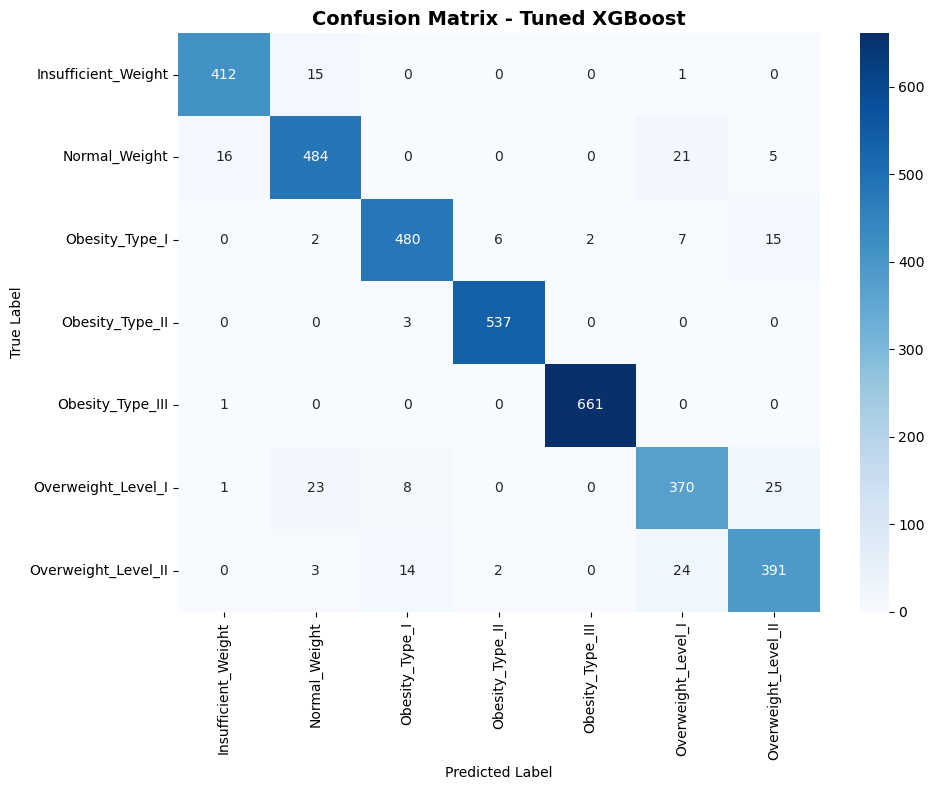

In [46]:
print("\nDETAILED CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_val_split, y_pred, target_names=le_target.classes_))

# Per-class accuracy
print("PER-CLASS ACCURACY:")
print("="*60)
for i, class_name in enumerate(le_target.classes_):
    class_mask = (y_val_split == i)
    if class_mask.sum() > 0:
        class_acc = accuracy_score(y_val_split[class_mask], y_pred[class_mask])
        print(f"{class_name:30s}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_val_split, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Confusion Matrix - Tuned XGBoost', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

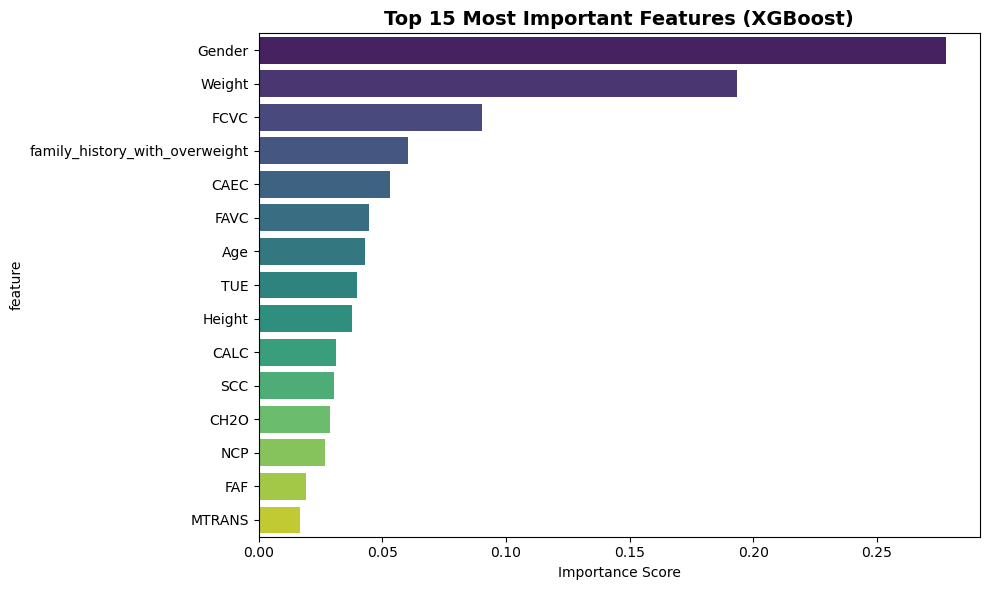


Top 10 Most Important Features:
                       feature  importance
                        Gender    0.277765
                        Weight    0.193432
                          FCVC    0.090484
family_history_with_overweight    0.060597
                          CAEC    0.053142
                          FAVC    0.044535
                           Age    0.042852
                           TUE    0.039666
                        Height    0.037683
                          CALC    0.031415


In [47]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


In [48]:
print("CROSS-VALIDATION RESULTS")
print(f"Best CV Score: {random_search.best_score_:.4f} ({random_search.best_score_*100:.2f}%)")

CROSS-VALIDATION RESULTS
Best CV Score: 0.9131 (91.31%)


In [49]:
print("\n" + "="*60)
print("MAKING TEST PREDICTIONS")
print("="*60)

X_test = test_processed.drop(['id'], axis=1, errors='ignore')
X_test_scaled = scaler_full.transform(X_test)

test_predictions = xgb_model.predict(X_test_scaled)
test_predictions_labels = le_target.inverse_transform(test_predictions)

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'WeightCategory': test_predictions_labels
})

submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(f"Total predictions: {len(submission)}")

print("\nFirst 10 predictions:")
print(submission.head(10))

print("\nPrediction distribution:")
pred_dist = submission['WeightCategory'].value_counts().sort_index()
for category, count in pred_dist.items():
    pct = (count / len(submission)) * 100
    print(f"   {category:30s}: {count:4d} ({pct:5.2f}%)")


MAKING TEST PREDICTIONS
Submission file created: submission.csv
Total predictions: 5225

First 10 predictions:
      id       WeightCategory
0  15533     Obesity_Type_III
1  15534   Overweight_Level_I
2  15535  Overweight_Level_II
3  15536      Obesity_Type_II
4  15537        Normal_Weight
5  15538  Insufficient_Weight
6  15539       Obesity_Type_I
7  15540     Obesity_Type_III
8  15541   Overweight_Level_I
9  15542       Obesity_Type_I

Prediction distribution:
   Insufficient_Weight           :  656 (12.56%)
   Normal_Weight                 :  743 (14.22%)
   Obesity_Type_I                :  685 (13.11%)
   Obesity_Type_II               :  833 (15.94%)
   Obesity_Type_III              : 1063 (20.34%)
   Overweight_Level_I            :  566 (10.83%)
   Overweight_Level_II           :  679 (13.00%)
